In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFUEffectiveNet Dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 110/110 [00:02<00:00, 42.64it/s]


In [ ]:
X_train.shape

(3190, 224, 224, 3)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

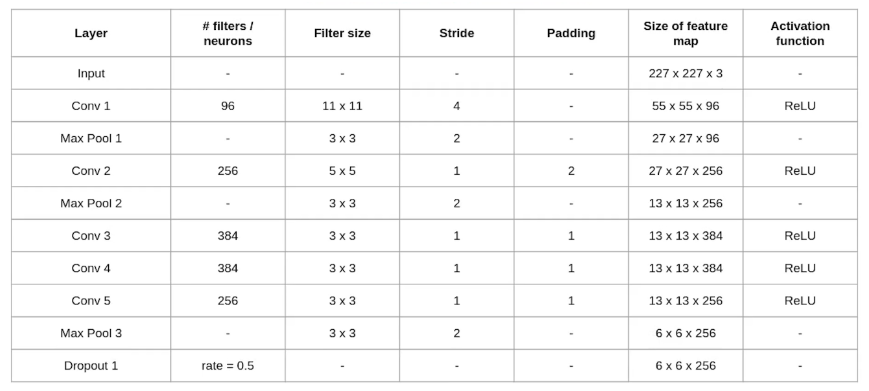

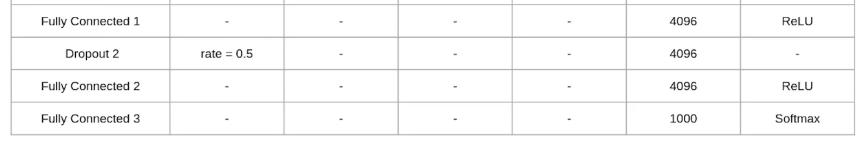

Model Build

In [ ]:
import tensorflow
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
 
 
def bn_rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    return x
 
 
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor
 
 
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x
 

k = 32
theta = 0.5
repetitions = 6, 12, 24, 16
 
input = Input(shape=(224, 224, 3))
 
x = Conv2D(2*k, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)
 
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
 
x = GlobalAvgPool2D()(d)
 
output = Dense(2, activation='softmax')(x)
 
from tensorflow.keras import Model 
model = Model(input, output,  name='DenseNet121')

In [ ]:
model.summary()

# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='DenseNet121.png')

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DenseNet121.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.05, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7987
Epoch 1: val_accuracy improved from -inf to 0.59722, saving model to DenseNet121.h5
86/86 [==============================] - 64s 439ms/step - loss: 0.5862 - accuracy: 0.7987 - val_loss: 6.7570 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8489
Epoch 2: val_accuracy did not improve from 0.59722
86/86 [==============================] - 30s 350ms/step - loss: 0.3943 - accuracy: 0.8489 - val_loss: 0.9748 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.8354
Epoch 3: val_accuracy did not improve from 0.59722

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
86/86 [==============================] - 31s 361ms/step - loss: 0.4762 - accuracy: 0.8354 - val_loss: 1.8696 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 4/50
86/86 [==

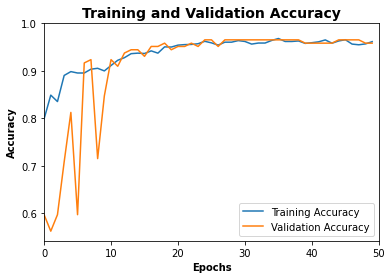

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,50])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('DenseNet121TV1',dpi=400)
plt.show()

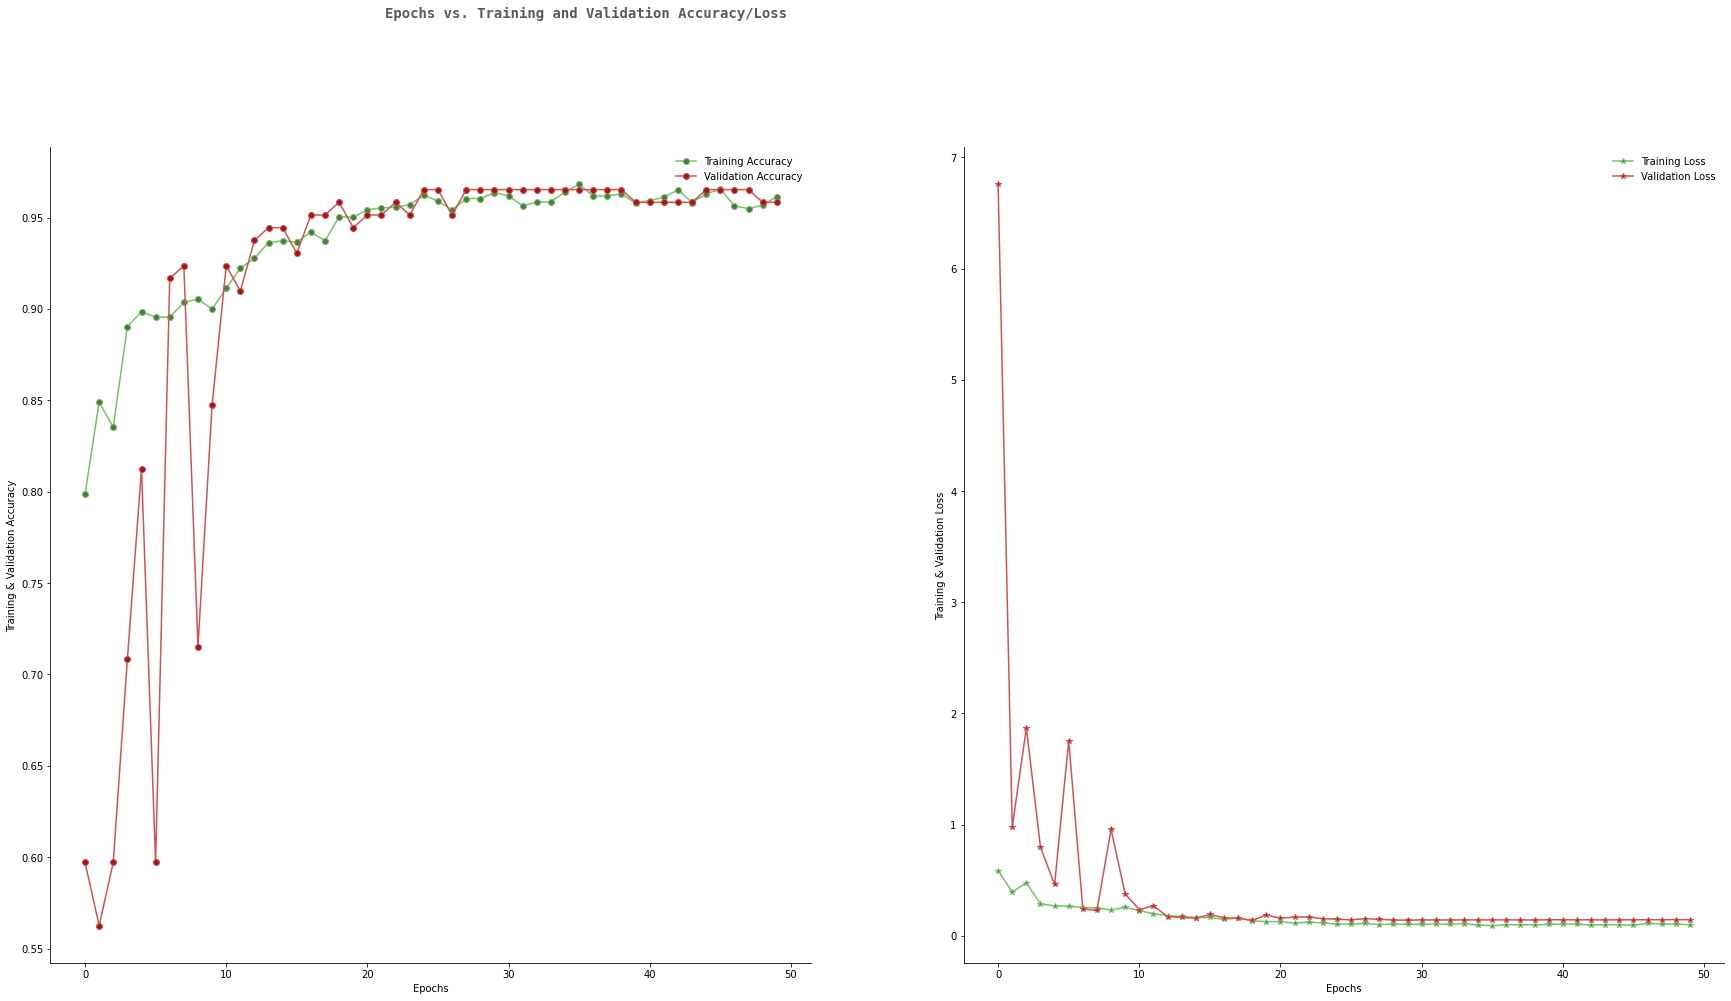

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2,figsize=(30,15))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='#313131',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training & Validation Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='*',markerfacecolor='#4F7942',color='#74C365',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='*',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.savefig('DenseNet121TV2',dpi=700)
fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       195
           1       0.94      0.94      0.94       124

    accuracy                           0.96       319
   macro avg       0.95      0.95      0.95       319
weighted avg       0.96      0.96      0.96       319



In [ ]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


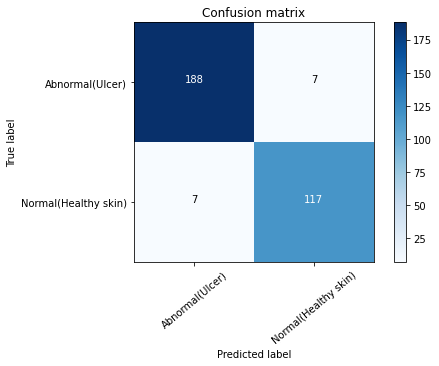

In [ ]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('DenseNet121CM',dpi=400)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.956 Precision: 0.944  Recall: 0.944 F1 Score: 0.944 AUC Score: 0.954


In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [ ]:
recall=TP/float(TP+FN)
print(' Recall: %.3f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.3f' % precision)



 Recall: 0.944
 Precision: 0.944


In [ ]:
f1=(2*precision*recall)/(recall+precision)

In [ ]:
print('F1 Score: %.3f' % f1)

F1 Score: 0.944


In [ ]:

print( 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))

AUC Score: 0.954


In [ ]:
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.3f' % mean_squared_error(y_test_new, pred))

Error Rate: 0.044


In [ ]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)

Specificity: 0.964


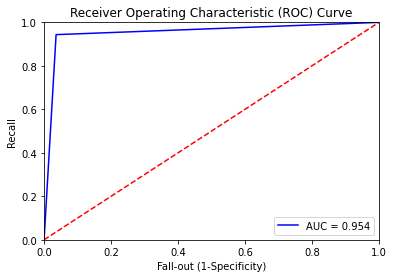

In [ ]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [ ]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))
print('val_accuracy: {0:0.2f}%'.format(np.round((history.history['val_accuracy'][-1])*100, 2)))

Accuracy: 95.61%
Precision: 94.35%
Recall or Sensitivity: 94.35%
Specificity: 96.41%
F1-score: 94.35%
AUC-score: 95.38%
Train acc: 96.15%
val_accuracy: 95.83%


In [ ]:
"""# Test the Model"""
 
y_pred = model.predict(X_test)
y_pred.round(2)
 
y_test
 
model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 98ms/step - loss: 0.1133 - accuracy: 0.9561


[0.11329591274261475, 0.9561128616333008]